### SHAP for income prediction

SHAP is a model-agnostic explainer for tabular data. If using this explainer, please cite the original work: https://github.com/slundberg/shap.

In [1]:
import sys
import os

module_path = os.path.abspath('E:/Codes/OmniXAI/')
if module_path not in sys.path:
    sys.path.append(module_path)

# For Jupyter notebooks or interactive environments where __file__ is not defined
try:
    # Try to use __file__ if available
    directory = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # If __file__ is not defined (e.g., in Jupyter), use the current working directory
    directory = os.path.abspath('')
    
sys.path.append(os.path.dirname(directory))

In [2]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [3]:
import os
import sklearn
import xgboost
import numpy as np
import pandas as pd
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import ShapTabular

The dataset used in this example is for income prediction (https://archive.ics.uci.edu/ml/datasets/adult). We recommend using `Tabular` to represent a tabular dataset, which can be constructed from a pandas dataframe or a numpy array. To create a `Tabular` instance given a numpy array, one needs to specify the data, the feature names, the categorical feature names (if exists) and the target/label column name (if exists).

In [4]:
feature_names = [
    "Age", "Workclass", "fnlwgt", "Education",
    "Education-Num", "Marital Status", "Occupation",
    "Relationship", "Race", "Sex", "Capital Gain",
    "Capital Loss", "Hours per week", "Country", "label"
]
data = np.genfromtxt(os.path.join('../data', 'adult.data'), delimiter=', ', dtype=str)
tabular_data = Tabular(
    data,
    feature_columns=feature_names,
    categorical_columns=[feature_names[i] for i in [1, 3, 5, 6, 7, 8, 9, 13]],
    target_column='label'
)
print(tabular_data)

      Age         Workclass  fnlwgt   Education Education-Num  \
0      39         State-gov   77516   Bachelors            13   
1      50  Self-emp-not-inc   83311   Bachelors            13   
2      38           Private  215646     HS-grad             9   
3      53           Private  234721        11th             7   
4      28           Private  338409   Bachelors            13   
...    ..               ...     ...         ...           ...   
32556  27           Private  257302  Assoc-acdm            12   
32557  40           Private  154374     HS-grad             9   
32558  58           Private  151910     HS-grad             9   
32559  22           Private  201490     HS-grad             9   
32560  52      Self-emp-inc  287927     HS-grad             9   

           Marital Status         Occupation   Relationship   Race     Sex  \
0           Never-married       Adm-clerical  Not-in-family  White    Male   
1      Married-civ-spouse    Exec-managerial        Husband  Wh

`TabularTransform` is a special transform designed for tabular data. By default, it converts categorical features into one-hot encoding, and keeps continuous-valued features (if one wants to normalize continuous-valued features, set the parameter `cont_transform` in `TabularTransform` to `Standard` or `MinMax`). The `transform` method of `TabularTransform` will transform a `Tabular` instance into a numpy array. If the `Tabular` instance has a target/label column, the last column of the transformed numpy array will be the target/label. 

If one wants some other transformations that are not supported in the library, one can simply convert the `Tabular` instance into a pandas dataframe by calling `Tabular.to_pd()` and try different transformations with it.

After data preprocessing, we can train a XGBoost classifier for this task (one may try other classifiers). 

In [5]:
np.random.seed(1)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)
train, test, labels_train, labels_test = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80)
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

gbtree = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
gbtree.fit(train, labels_train)
print('Test accuracy: {}'.format(
    sklearn.metrics.accuracy_score(labels_test, gbtree.predict(test))))

Training data shape: (26048, 108)
Test data shape:     (6513, 108)
Test accuracy: 0.865806847842776


The prediction function takes a `Tabular` instance as its inputs, and outputs the class probabilities for classification tasks or the estimated values for regression tasks. In this example, we simply call `transformer.transform` to do data preprocessing followed by the prediction function of `gbtree`.

In [6]:
predict_function=lambda z: gbtree.predict_proba(transformer.transform(z))

To initialize a SHAP explainer, we need to set:
  
  - `training_data`: The data used to initialize a SHAP explainer. ``training_data`` can be the training dataset for training the machine learning model. If the training dataset is too large, ``training_data`` can be a subset of it by applying `omnixai.sampler.tabular.Sampler.subsample`.
  - `predict_function`: The prediction function corresponding to the model.
  - `mode`: The task type, e.g., "classification" or "regression".

In [7]:
explainer = ShapTabular(
    training_data=tabular_data,
    predict_function=predict_function,
    nsamples=100
)
# Apply an inverse transform, i.e., converting the numpy array back to `Tabular`
test_instances = transformer.invert(test)
test_x = test_instances[1653:1655]

SHAP generates local explanations, e.g. `explainer.explain` is called given the test instances. `ipython_plot` plots the generated explanations in IPython. Parameter `index` indicates which instance in `test_x` to plot, e.g., `index = 0` means plotting the first instance in `test_x`.

  0%|          | 0/2 [00:00<?, ?it/s]

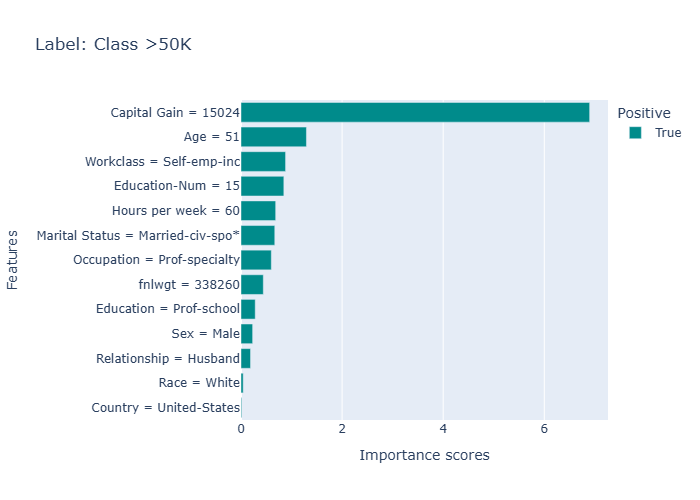

In [8]:
explanations = explainer.explain(test_x)
explanations.ipython_plot(index=0, class_names=class_names)